# Input analysis 

Candidates:

278,
221 &
213



First, we need to load relevant modules:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from fitter import Fitter
from scipy import stats
import numpy as np
import numpy as np

# setting seed for reproducibility
np.random.seed(69)

We will then load our data:

In [5]:
# loading data
private_activity_times = pd.read_excel("MillerPainTreatmentCenterData.xlsx", sheet_name = "Exhibit2")
private_attending_times = pd.read_excel("MillerPainTreatmentCenterData.xlsx", sheet_name = "Exhibit3")
private_attending_pchange = pd.read_excel("MillerPainTreatmentCenterData.xlsx", sheet_name = "Exhibit4")
mptc_activity_new = pd.read_excel("MillerPainTreatmentCenterData.xlsx", sheet_name = "Exhibit6")
mptc_activity_return = pd.read_excel("MillerPainTreatmentCenterData.xlsx", sheet_name = "Exhibit7")


Lastly, we define functions for our later analysis:

In [6]:



# list of standard distributions to be used in the analysis
# these are all the relevant distributions available in JaamSim. Beta and erlang are not included, see report for details.
distributions = ['norm', 'lognorm', 'gamma', 'expon', 'triang', 'weibull_min']

# initialize the results dataframe
results_df = pd.DataFrame(columns=["Distribution", "Location", "Scale", "Shape", "Mean"])


def plot_data(data, bins = 15):

    """
    Plots a histogram of the provided data using a specified number of bins.

    Parameters:
    - data (pandas.Series or pandas.DataFrame): Data to be plotted as a histogram.
    - bins (int, optional): Number of bins to use for the histogram. Defaults to 15.

    Returns:
    - None: Displays a histogram of the data.
    """
    
    data.plot.hist(bins= bins)
    plt.show()


def fit_and_analyse(data, distributions = ['expon', 'gamma', 'norm', 'lognorm', 'weibull_min', 'triang'], bins = 15):
    """
    Fits multiple distributions to the data and analyzes them, printing a summary of the fit results.

    Parameters:
    - data (pandas.Series or numpy.array): Data to fit the distributions to.
    - distributions (list, optional): List of distribution names to fit. Defaults to commonly used distributions.
    - bins (int, optional): Number of bins to use for histogramming the data. Defaults to 15.

    Returns:
    - fitDist (Fitter object): Object containing information about the fitted distributions.
    """

    # fitting the distribution
    fitDist = Fitter(data, bins = int(bins), distributions = distributions)
    fitDist.fit(n_jobs = -1) # using all cores
    print(fitDist.summary()) # fitting summary with AIC, BIC, KS, etc.
    print("\n----------------------------------\n")

    return fitDist # return the fitted distribution object for later use


def goodness_of_fit(data, dist_list, fitDist):

    """
    Evaluates the goodness of fit for specified distributions and plots the fit results.

    Parameters:
    - data (pandas.Series or numpy.array): Data used for fitting.
    - dist_list (list): List of distribution names to evaluate.
    - fitDist (Fitter object): Fitter object containing fitted parameters.

    Returns:
    - None: Displays a plot of the fitted distributions and prints a DataFrame of goodness of fit results.
    """

    num_dists = len(dist_list)
    results = []
    # Create a figure with subplots arranged in one row
    fig, axs = plt.subplots(1, num_dists, figsize=(5 * num_dists, 5))  # Adjust figure size as needed

    # Make axs a list if only one plot to keep indexing consistent
    if num_dists == 1:
        axs = [axs]

    
    for idx, dist in enumerate(dist_list):
        if dist in ['expon', 'norm']:
            # Use the first and second parameters for 'expon' and 'norm'
            known_params = {
                'loc': fitDist.fitted_param[dist][0],
                'scale': fitDist.fitted_param[dist][1]
            }
        if dist in ['erlang', 'gamma']:
            # Use the second and third parameters for other distributions
            known_params = {
                'a': fitDist.fitted_param[dist][0],
                'loc': fitDist.fitted_param[dist][1],
                'scale': fitDist.fitted_param[dist][2]
            }
        if dist in ['lognorm']:
            # Use the second and third parameters for other distributions
            known_params = {
                's': fitDist.fitted_param[dist][0],
                'loc': fitDist.fitted_param[dist][1],
                'scale': fitDist.fitted_param[dist][2]
            }
        if dist in ['triang', 'weibull_min']:
            # Use the second and third parameters for other distributions
            known_params = {
                'c': fitDist.fitted_param[dist][0],
                'loc': fitDist.fitted_param[dist][1],
                'scale': fitDist.fitted_param[dist][2]
            } 
    
        try:
            res = stats.goodness_of_fit(
                getattr(stats, dist), 
                data,
                known_params=known_params,
                statistic='ks')

            # Plot the fit if available
            if hasattr(res, 'fit_result') and hasattr(res.fit_result, 'plot'):
                axs[idx].title.set_text(f'{dist} Fit')
                res.fit_result.plot(ax=axs[idx])

                results.append({
                    'Distribution': dist.capitalize(),
                    'P-value': res.pvalue})
            
            else: print(f"No plot method available for {dist}")

        # Catch any exceptions and print them
        except Exception as e:
            print(f"Error in goodness of fit test for {dist}: {e}")

    print("\n----------------------------------")
    results_df = pd.DataFrame(results)
    print(results_df.to_string(index=False))
    print("----------------------------------")
    plt.tight_layout()
    plt.show()



def fit_params(data, fitDist, dist_name):

    """

    Parameters:
    - data (pandas.Series or numpy.array): Data to fit.
    - fitDist (Fitter object): Object containing fitted parameters for distributions.
    - dist_name (str): Name of the distribution to fit and calculate mean.

    Returns:
    - None: Updates global DataFrame with fitting results and prints the results.
    """

    global results_df  # Declare to modify the global variable

    dist_name = dist_name.lower()
    print("----------------------------------")

    if dist_name in fitDist.fitted_param:
        params = fitDist.fitted_param[dist_name]
        row = {"Distribution": dist_name.capitalize()}

        if dist_name in ['expon', 'norm']:
            loc, scale = params
            print(f"{dist_name.capitalize()} parameters:\n")
            print(f"location: {loc}, scale: {scale}\n")
            row.update({"Location": loc, "Scale": scale})

            if dist_name == 'expon':
                mean_expon = stats.expon.mean(loc=loc, scale=scale)
                print(f"Mean exponential = {mean_expon}\n")
                row.update({"Mean": mean_expon})

        else:
            shp1, loc, scale = params
            print(f"{dist_name.capitalize()} parameters:\n")
            print(f"shape: {shp1}, location: {loc}, scale: {scale}\n")
            row.update({"Shape": shp1, "Location": loc, "Scale": scale})

            if dist_name == 'gamma':
                mean_gamma = stats.gamma.mean(a=shp1, loc= loc, scale=scale)
                print(f"Mean gamma = {mean_gamma}\n")
                row.update({"Mean": mean_gamma})

            if dist_name == 'erlang': #not included in our case, but included for completeness
                mean_erlang = stats.erlang.mean(a=shp1, loc= loc, scale=scale)
                print(f"Mean erlang = {mean_erlang}\n")
                row.update({"Mean": mean_erlang})

        # Append the results row to the DataFrame
        results_df = results_df.append(row, ignore_index=True)

    else:
        print(f"No parameters found for {dist_name}")

    print("----------------------------------")

### Registration times in private clinic

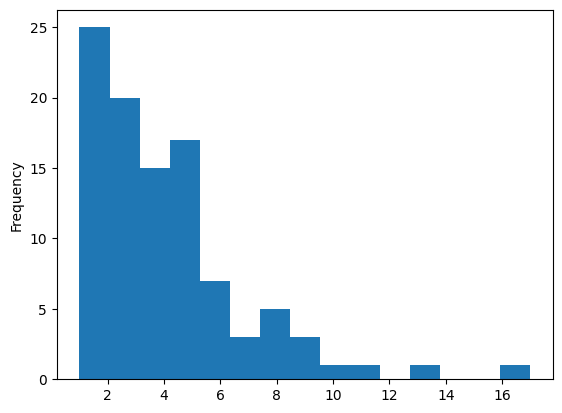

2024-04-22 10:36:53.112 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.066184)
2024-04-22 10:36:53.127 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.005397)
2024-04-22 10:36:53.131 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.013692)
2024-04-22 10:36:53.137 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.007819)
2024-04-22 10:36:53.140 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.03625)
2024-04-22 10:36:53.164 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.043754)


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon           0.005397  112.119184  117.309424     inf      0.198663   
gamma           0.007819  120.454920  128.240279     inf      0.123484   
lognorm         0.013692  120.936955  128.722314     inf      0.108260   
norm            0.036250  151.516040  156.706280     inf      0.179208   
triang          0.043754   98.557690  106.343050     inf      0.319598   

            ks_pvalue  
expon    6.705994e-04  
gamma    8.961641e-02  
lognorm  1.824391e-01  
norm     2.973725e-03  
triang   1.706788e-09  

----------------------------------



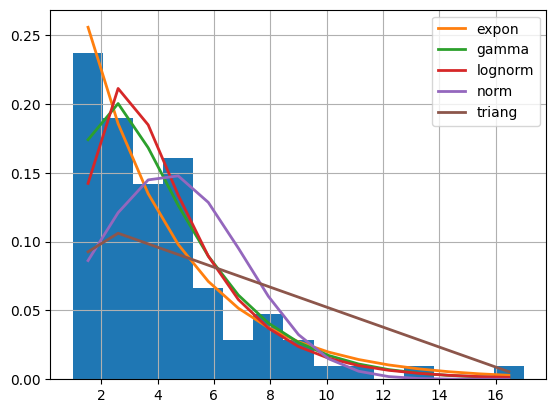

In [7]:

# load data
registration_private = private_activity_times['Registration']
#plotting and fitting the data
plot_data(registration_private)
fit_Registration = fit_and_analyse(registration_private)



Based on the KS p-value, we will further assess the gamma and lognormal distributions: 


----------------------------------
Distribution  P-value
     Lognorm   0.1765
       Gamma   0.0922
----------------------------------


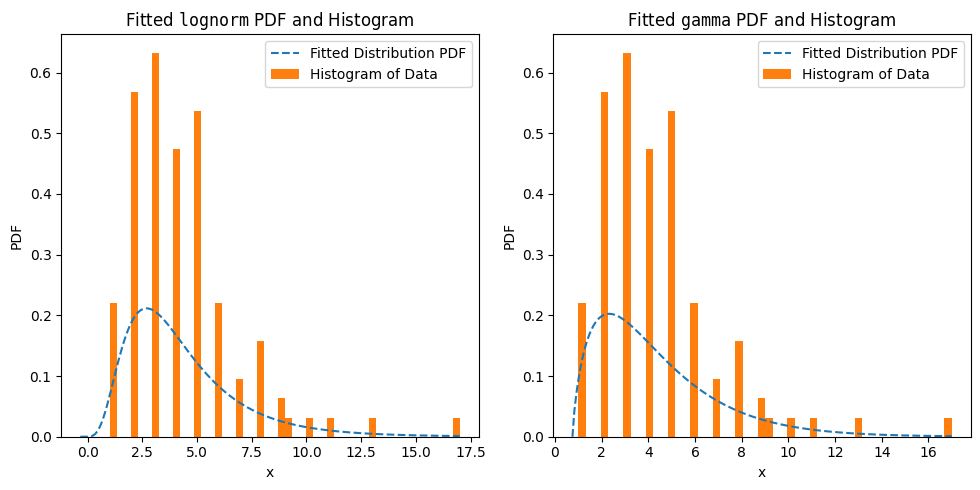

In [8]:
#goodness of fit testing
dist_list = ['lognorm', 'gamma']
goodness_of_fit(registration_private, dist_list, fit_Registration)

Unfortunately, the bins in the scipy.stats.goodness_of_fit are hard coded, making the scale of the histogram very different to the fitted distribution PDF. 

It seems that the lognorm distribution is the best fit, we will find the parameters:

In [9]:
# finding parameters
dist_params = fit_params(registration_private, fit_Registration, 'lognorm')

----------------------------------
Lognorm parameters:

shape: 0.5385173526476907, location: -0.34178142035364656, scale: 4.048761891113067

----------------------------------


### Vitals time usage in private clinic

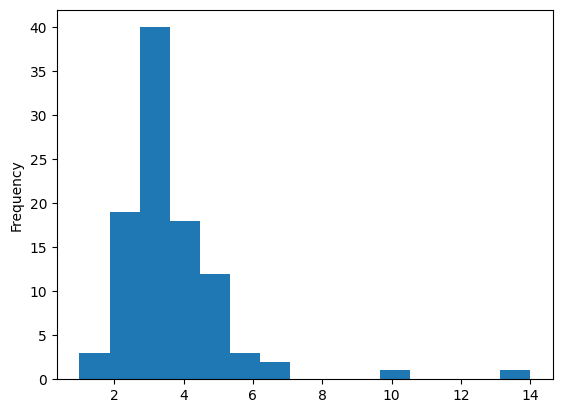

2024-04-22 10:36:54.617 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.072074)
2024-04-22 10:36:54.619 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.040032)
2024-04-22 10:36:54.621 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.192428)
2024-04-22 10:36:54.699 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.04702)
2024-04-22 10:36:54.735 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.309415)
2024-04-22 10:36:54.845 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.155289)


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
lognorm         0.040032  138.502833  146.288193     inf      0.208974   
gamma           0.047020  145.984283  153.769643     inf      0.202023   
norm            0.072074  196.387044  201.577284     inf      0.245088   
triang          0.155289   90.152826   97.938186     inf      0.441595   
expon           0.192428  109.010232  114.200472     inf      0.324840   

            ks_pvalue  
lognorm  2.856690e-04  
gamma    5.102835e-04  
norm     1.009914e-05  
triang   4.213929e-18  
expon    8.436270e-10  

----------------------------------



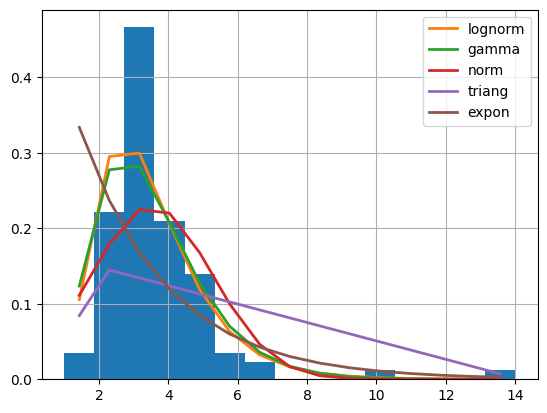

In [10]:

#loading the data
vitals_private = private_activity_times['Vitals']

#plotting the data
plot_data(vitals_private)
fit_vitals = fit_and_analyse(vitals_private, distributions)

The  gamma is barely above the critical level on the KS p-level. Based on the visualisations and the stats, we will further test the lognorm, gamma and norm. 


----------------------------------
Distribution  P-value
       Gamma   0.0004
     Lognorm   0.0003
        Norm   0.0001
----------------------------------


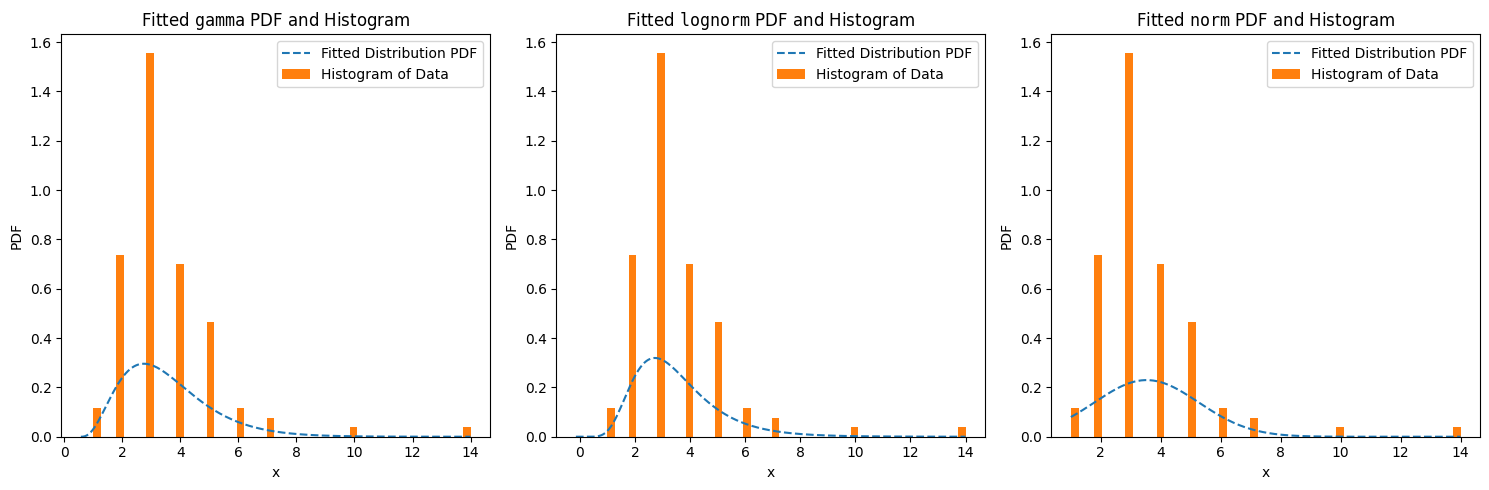

In [11]:
dist_list = ['gamma', 'lognorm', 'norm']
goodness_of_fit(vitals_private, dist_list, fit_vitals)

None of the fitted distributions are closely following our data, all are rejected by the GOF-test. The gamma is the one that shows the best scores, based on the KS test.

In [12]:
dist_params = fit_params(vitals_private, fit_vitals, 'gamma')

----------------------------------
Gamma parameters:

shape: 3.7513592292833717, location: 0.5673847190467161, scale: 0.7884780536396723

Mean gamma = 3.52524914265529

----------------------------------


### PA time usage in private clinic

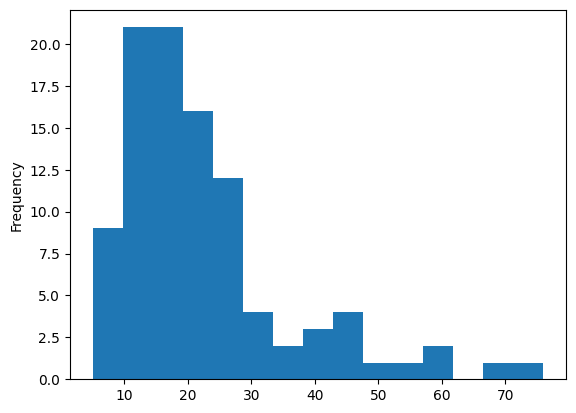

2024-04-22 10:36:56.499 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.000139)
2024-04-22 10:36:56.546 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.00057)
2024-04-22 10:36:56.570 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000286)
2024-04-22 10:36:56.586 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.001449)
2024-04-22 10:36:56.592 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.001538)
2024-04-22 10:36:56.699 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.00149)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
lognorm             0.000139  158.157146  165.912049     inf      0.057178   
gamma               0.000286  158.008693  165.763595     inf      0.080034   
weibull_min         0.000570         inf         inf     inf      0.075763   
norm                0.001449  169.346600  174.516535     inf      0.172644   
triang              0.001490  140.796302  148.551205     inf      0.290899   

                ks_pvalue  
lognorm      8.874607e-01  
gamma        5.303557e-01  
weibull_min  6.000641e-01  
norm         5.038035e-03  
triang       7.703719e-08  

----------------------------------



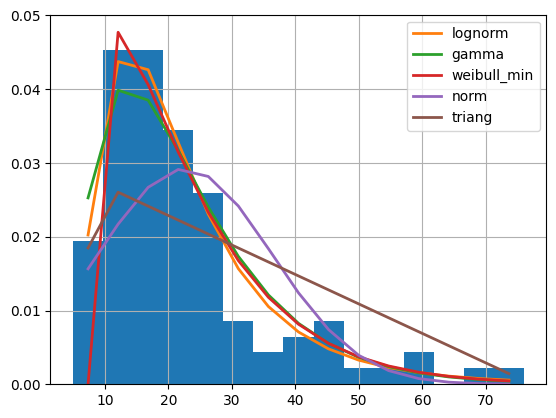

In [13]:


pa_private = private_activity_times[private_activity_times["Physicians Assistant"].notnull()]["Physicians Assistant"]

plot_data(pa_private)
pa_private_fit = fit_and_analyse(pa_private, distributions)




Based on the histogram and the KS P-values we will explore lognorm, weibull and gamma.


----------------------------------
Distribution  P-value
     Lognorm   0.8855
 Weibull_min   0.5944
       Gamma   0.5336
----------------------------------


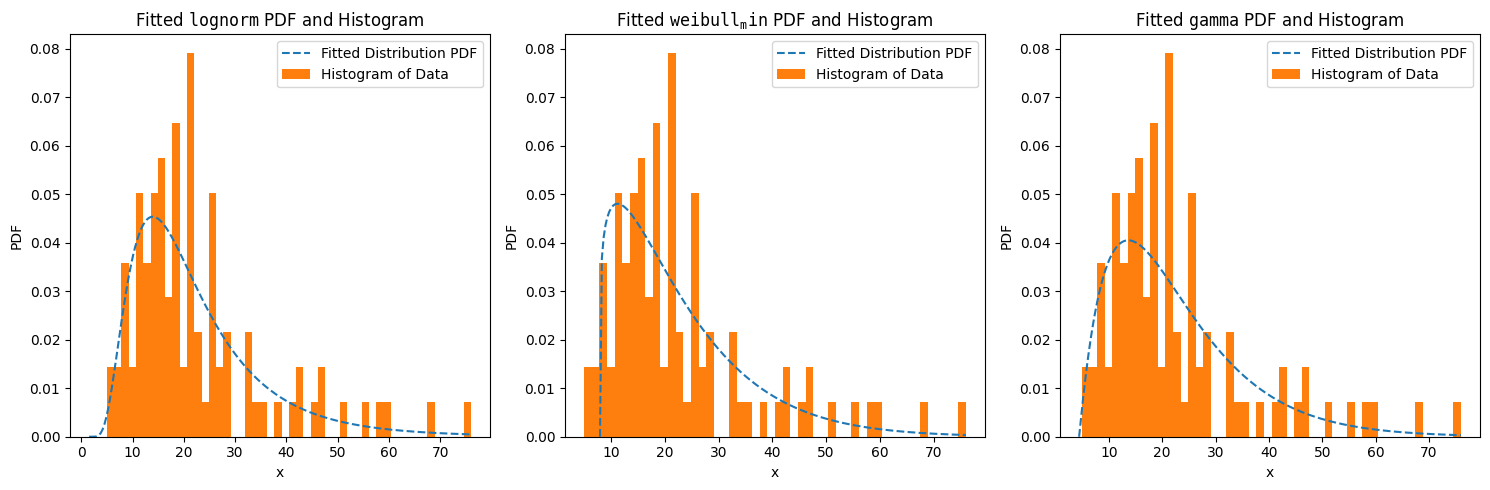

In [14]:
dist_list = ['lognorm', 'weibull_min', 'gamma']
goodness_of_fit(pa_private, dist_list, pa_private_fit)

Based on our goodness of fit-results, we will use the lognorm-distribution, and extract its fitted parameters:

In [15]:
fit_params(pa_private, pa_private_fit, 'lognorm')

----------------------------------
Lognorm parameters:

shape: 0.5939678623257564, location: 1.5345618600595754, scale: 17.65508602862503

----------------------------------


### Check out time usage in private clinic 

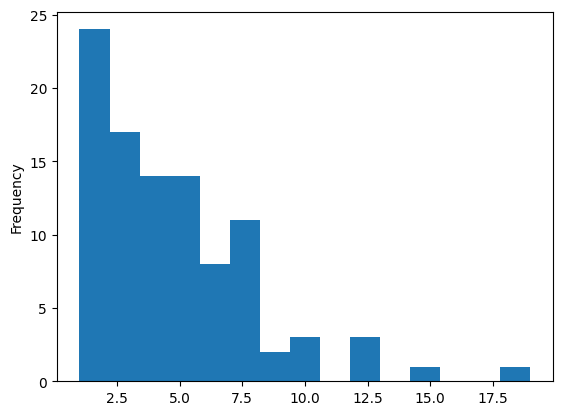

2024-04-22 10:36:58.383 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.073343)
2024-04-22 10:36:58.495 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.017856)
2024-04-22 10:36:58.505 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.005279)
2024-04-22 10:36:58.512 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.021772)
2024-04-22 10:36:58.527 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.015068)
2024-04-22 10:36:58.645 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.021976)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon               0.005279  115.941047  121.110982     inf      0.170595   
gamma               0.015068  123.618281  131.373183     inf      0.330960   
weibull_min         0.017856  120.725225  128.480128     inf      0.321727   
norm                0.021772  144.840600  150.010535     inf      0.170245   
triang              0.021976  100.210147  107.965050     inf      0.314177   

                ks_pvalue  
expon        5.799807e-03  
gamma        4.565256e-10  
weibull_min  1.587305e-09  
norm         5.940050e-03  
triang       4.272255e-09  

----------------------------------



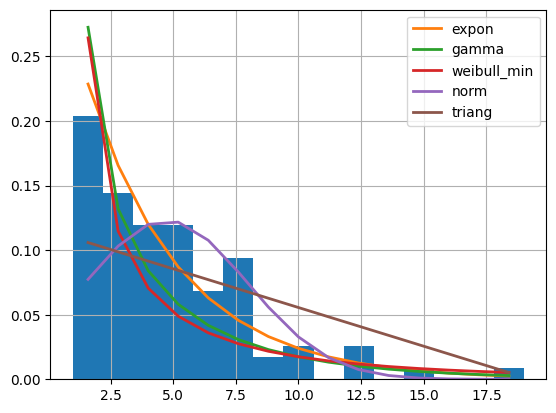

In [16]:
# code

check_out_private = private_activity_times[private_activity_times["Check Out"].notnull()]["Check Out"] 

plot_data(check_out_private)
check_out_private_fit = fit_and_analyse(check_out_private)


None of the distributions seems to be a very close fit. We will further test exponential and normal:


----------------------------------
Distribution  P-value
       Expon   0.0057
        Norm   0.0074
----------------------------------


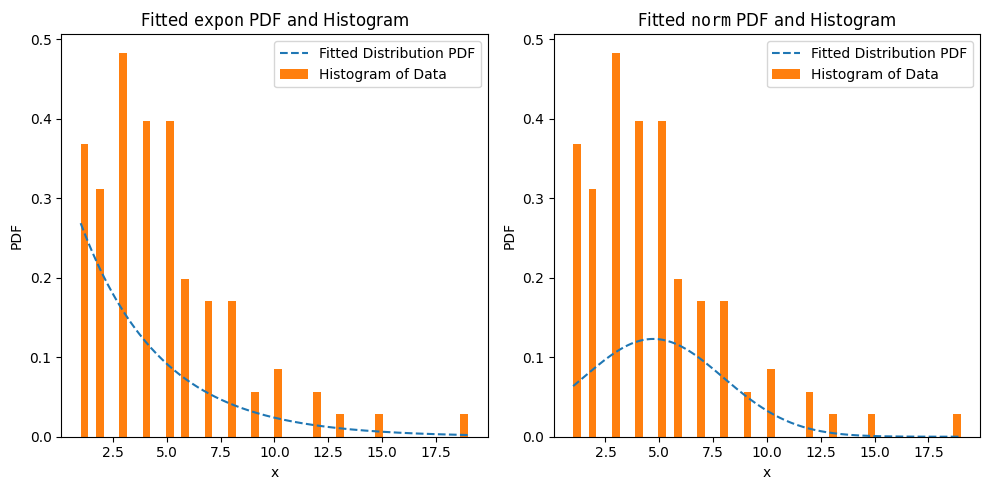

In [17]:
dist_list = ['expon', 'norm']
goodness_of_fit(check_out_private, dist_list, check_out_private_fit)


All our distributions are rejected by the GOF. However, based on the overall assessment of the KS-statistics, visual inspections, and the other metrics, we conclude the exponential distribution is the best fit available to us. 

In [18]:
fit_params(check_out_private, check_out_private_fit, 'expon')

----------------------------------
Expon parameters:

location: 0.9999999999998366, scale: 3.724489795918532

Mean exponential = 4.724489795918369

----------------------------------


### Appointment time minus arrival time before policy change:

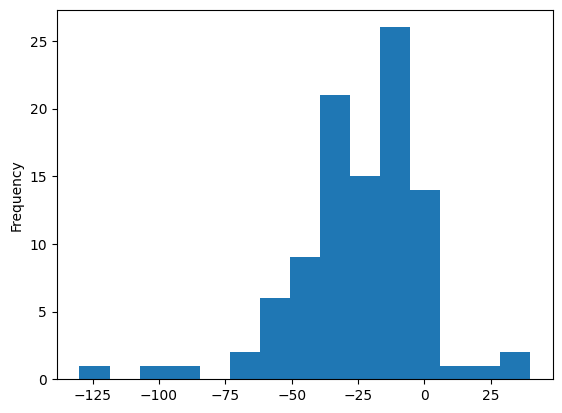

2024-04-22 10:36:59.606 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.001066)
2024-04-22 10:36:59.724 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.001491)
2024-04-22 10:36:59.752 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.000152)
2024-04-22 10:36:59.789 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.00013)
2024-04-22 10:36:59.805 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000175)
2024-04-22 10:36:59.848 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.000357)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.000130  187.522649  195.338160     inf      0.094352   
norm                0.000152  197.719243  202.929583     inf      0.108992   
gamma               0.000175  200.248862  208.064372     inf      0.124946   
triang              0.000357  166.380242  174.195753     inf      0.231515   
expon               0.001066  167.954737  173.165077     inf      0.428735   

                ks_pvalue  
weibull_min  3.154624e-01  
norm         1.725372e-01  
gamma        8.072396e-02  
triang       3.395730e-05  
expon        3.294958e-17  

----------------------------------



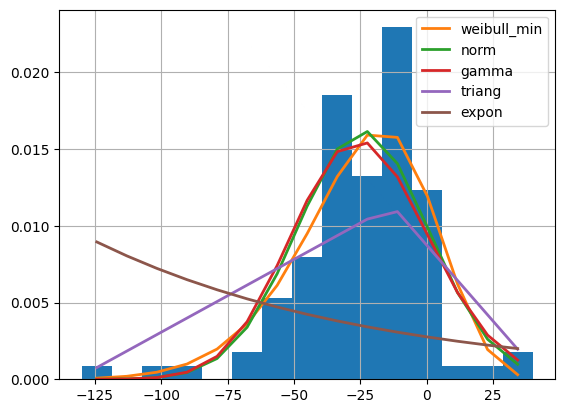

In [19]:
diff_appoint_arrival_before = private_attending_pchange['Appointment Time Minus Arrival Time Before Policy Change']

plot_data(diff_appoint_arrival_before)
diff_appoint_arrival_before_fit = fit_and_analyse(diff_appoint_arrival_before)


It seems that the weibull, normal and the gamma distributions are our best candidates. However, only the normal distribution is defined for $x<0$. We therefore only test the GOF for the normal distribution.


----------------------------------
Distribution  P-value
        Norm   0.1752
----------------------------------


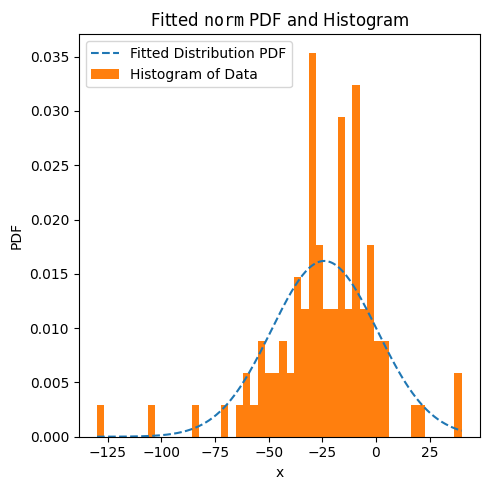

In [20]:
dist_list = ['norm']
goodness_of_fit(diff_appoint_arrival_before, dist_list, diff_appoint_arrival_before_fit)

The normal distribution is the best candidate, given our test results. We will extract the fitted parameters:

In [21]:

fit_params(diff_appoint_arrival_before, diff_appoint_arrival_before_fit, 'norm')


----------------------------------
Norm parameters:

location: -24.09, scale: 24.64430765917355

----------------------------------


### Appointment time minus arrival time after policy change:

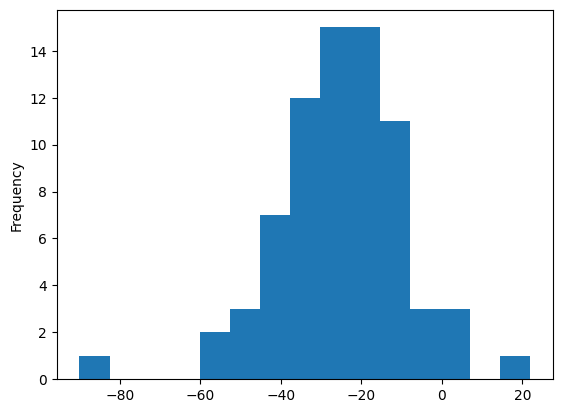

2024-04-22 10:37:00.719 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.002117)
2024-04-22 10:37:00.851 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.00325)
2024-04-22 10:37:00.856 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=8.6e-05)
2024-04-22 10:37:00.887 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.000112)
2024-04-22 10:37:00.906 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000112)
2024-04-22 10:37:00.968 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.000551)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
norm                0.000086  179.743360  184.324279     inf      0.104535   
weibull_min         0.000112  174.482702  181.354080     inf      0.123154   
gamma               0.000112  183.357008  190.228386     inf      0.107291   
triang              0.000551  153.733841  160.605219     inf      0.185940   
expon               0.002117  155.043536  159.624455     inf      0.426245   

                ks_pvalue  
norm         3.762088e-01  
weibull_min  2.008392e-01  
gamma        3.452933e-01  
triang       1.106928e-02  
expon        1.488906e-12  

----------------------------------



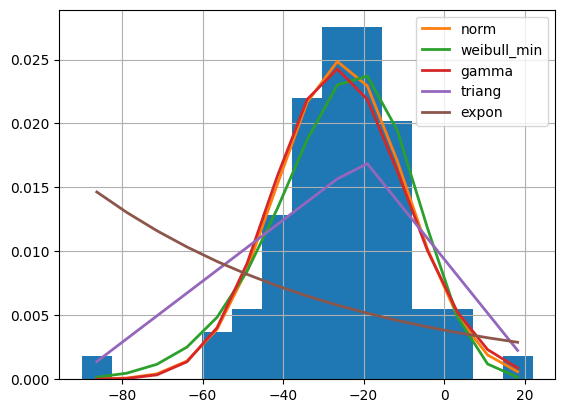

In [22]:
diff_appoint_arrival_after = private_attending_pchange[private_attending_pchange['Appointment Time Minus Arrival Time After Policy Change'].notnull()]['Appointment Time Minus Arrival Time After Policy Change']

plot_data(diff_appoint_arrival_after)
diff_appoint_arrival_after_fit = fit_and_analyse(diff_appoint_arrival_after)


The normaldistributions seems to be a clear candidate. 


----------------------------------
Distribution  P-value
        Norm   0.3787
 Weibull_min   0.1974
       Gamma   0.3464
----------------------------------


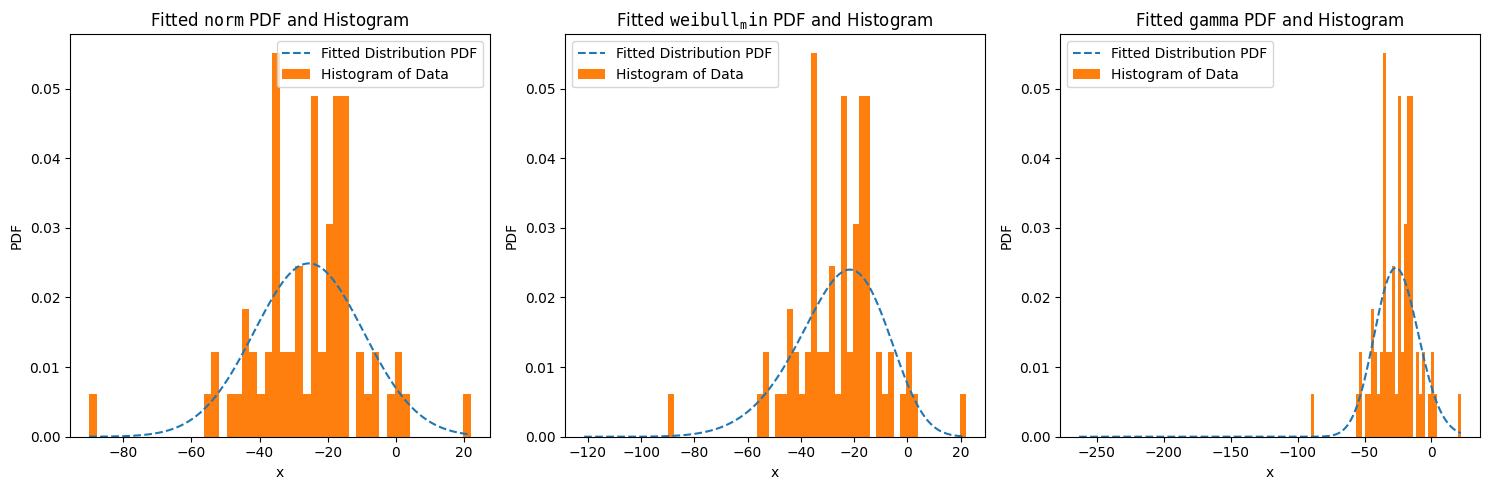

In [23]:
dist_list = ['norm', 'weibull_min', 'gamma']
goodness_of_fit(diff_appoint_arrival_after, dist_list, diff_appoint_arrival_after_fit)  

Overall, the normal distribution seems to be the best candidate.

In [24]:
fit_params(diff_appoint_arrival_after, diff_appoint_arrival_after_fit, 'norm')

----------------------------------
Norm parameters:

location: -25.54794520547945, scale: 16.02655424547956

----------------------------------


# Statistics for Miller Pain Treatment Center (MPTC)

We can now assess the field data from MPTC

### Resident review time for new patients

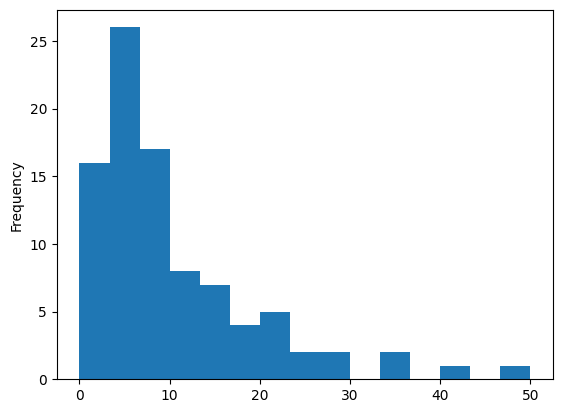

2024-04-22 10:37:02.498 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.014478)
2024-04-22 10:37:02.588 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.001806)
2024-04-22 10:37:02.591 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.004178)
2024-04-22 10:37:02.602 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.001846)
2024-04-22 10:37:02.607 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000748)
2024-04-22 10:37:02.667 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.004258)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
gamma               0.000748  153.384642  160.917221     inf      0.108573   
expon               0.001806  146.210180  151.231899     inf      0.172842   
weibull_min         0.001846  150.603105  158.135684     inf      0.098952   
norm                0.004178  170.888205  175.909924     inf      0.182330   
triang              0.004258  130.237836  137.770415     inf      0.323059   

                ks_pvalue  
gamma        2.173068e-01  
expon        7.571922e-03  
weibull_min  3.140238e-01  
norm         4.044242e-03  
triang       5.940236e-09  

----------------------------------



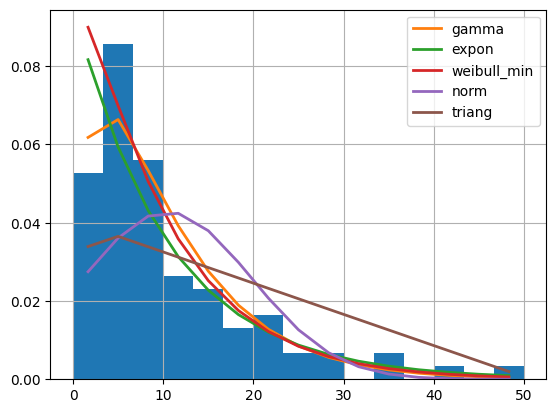

In [25]:

resident_review_new = mptc_activity_new['Resident Review']

plot_data(resident_review_new)
resident_review_new_fit = fit_and_analyse(resident_review_new)

We will further test the gamma and the weibull distributions:


----------------------------------
Distribution  P-value
       Gamma    0.220
 Weibull_min    0.307
----------------------------------


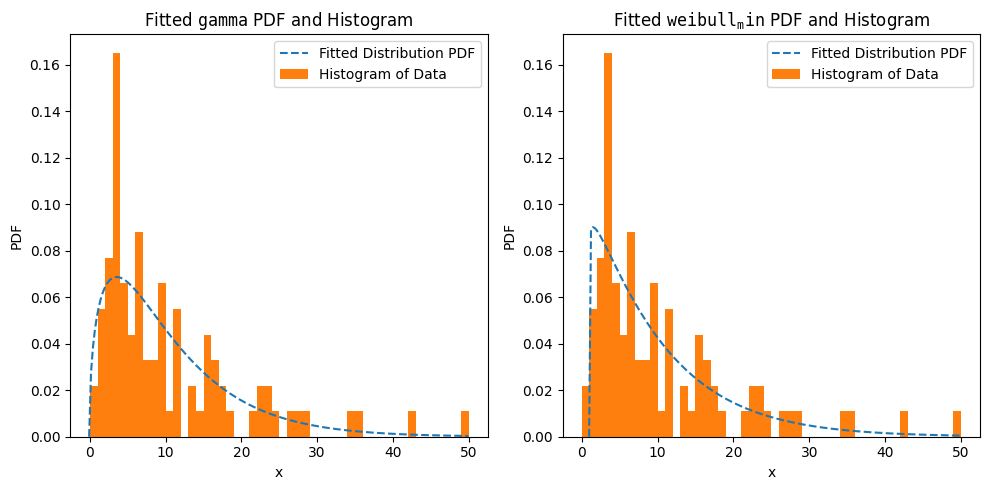

In [26]:
dist_list = ['gamma', 'weibull_min']  
goodness_of_fit(resident_review_new, dist_list, resident_review_new_fit)

Based on the KS-statistic and the goodness of fit, the Weibull distribution is our best candidate. 

In [27]:
fit_params(resident_review_new, resident_review_new_fit, 'weibull_min')

----------------------------------
Weibull_min parameters:

shape: 1.0476245305808796, location: 0.9889031336362433, scale: 9.648656099085827

----------------------------------


### Resident and patient times for new patients:

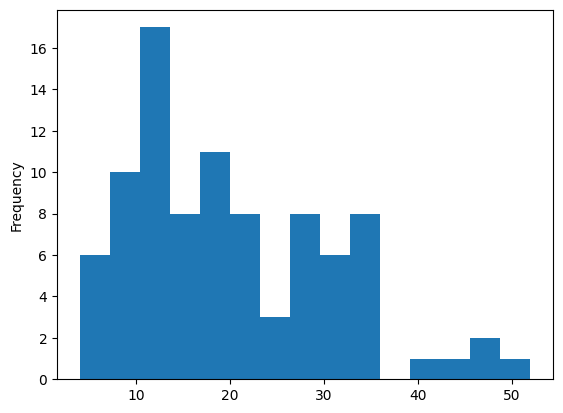

2024-04-22 10:37:03.935 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.001242)
2024-04-22 10:37:03.973 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.001193)
2024-04-22 10:37:03.990 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.001163)
2024-04-22 10:37:04.000 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.002146)
2024-04-22 10:37:04.001 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.00278)
2024-04-22 10:37:04.103 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.001277)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
gamma               0.001163  133.750350  141.249779     inf      0.076035   
weibull_min         0.001193  133.137603  140.637032     inf      0.078494   
lognorm             0.001242  134.922505  142.421934     inf      0.084962   
triang              0.001277  128.178965  135.678394     inf      0.117322   
norm                0.002146  135.577253  140.576872     inf      0.148665   

             ks_pvalue  
gamma         0.647275  
weibull_min   0.607933  
lognorm       0.507296  
triang        0.154926  
norm          0.033555  

----------------------------------



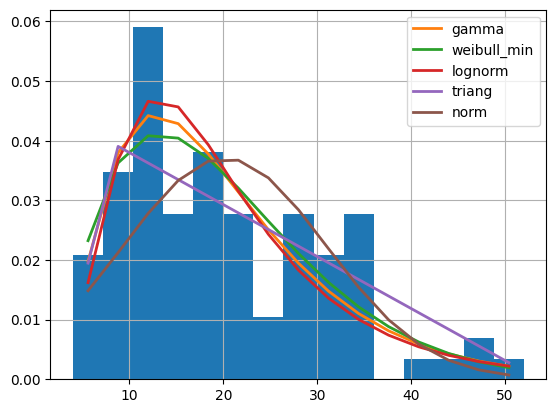

In [28]:
# using not null to remove nan values
resident_patient = mptc_activity_new[mptc_activity_new['Resident & Patient'].notnull()]['Resident & Patient']

plot_data(resident_patient)
resident_patient_fit = fit_and_analyse(resident_patient)

We will further test gamma and weibull:


----------------------------------
Distribution  P-value
       Gamma   0.6434
 Weibull_min   0.6052
----------------------------------


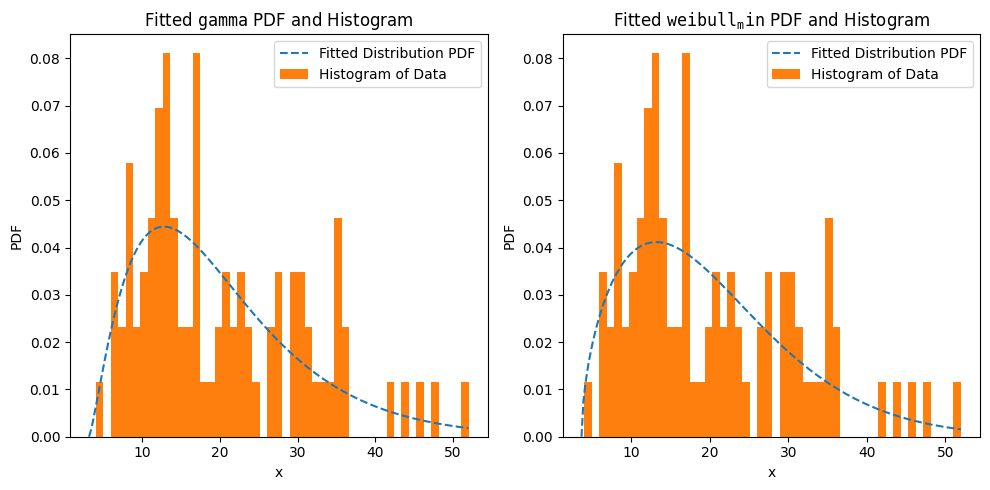

In [29]:
dist_list = [ 'gamma', 'weibull_min']
goodness_of_fit(resident_patient, dist_list, resident_patient_fit)

Overall, the gamma distribution ssems to be marginally better fit then the rest. 

In [30]:
fit_params(resident_patient, resident_patient_fit, 'gamma')

----------------------------------
Gamma parameters:

shape: 2.306444049216466, location: 3.1320924303851463, scale: 7.380829548508648

Mean gamma = 20.15556282082397

----------------------------------


### Teaching times for new patients

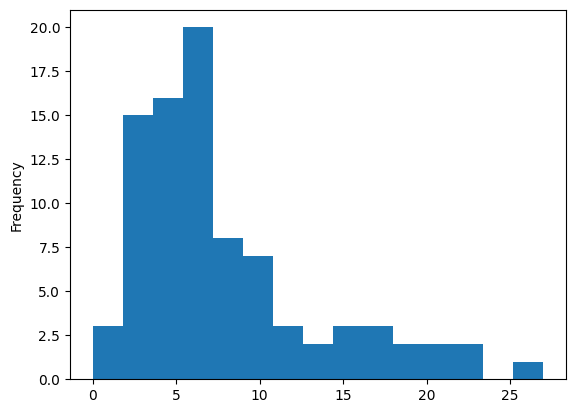

2024-04-22 10:37:05.420 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.015259)
2024-04-22 10:37:05.422 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.041557)
2024-04-22 10:37:05.475 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.003926)
2024-04-22 10:37:05.477 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.011393)
2024-04-22 10:37:05.487 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.003654)
2024-04-22 10:37:05.558 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.008905)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.003654         inf         inf     inf      0.111972   
gamma               0.003926  122.652559  130.050283     inf      0.115608   
triang              0.008905  111.300674  118.698399     inf      0.268833   
norm                0.011393  127.523646  132.455462     inf      0.201986   
expon               0.015259  117.406182  122.337998     inf      0.237139   

             ks_pvalue  
weibull_min   0.209125  
gamma         0.180625  
triang        0.000005  
norm          0.001375  
expon         0.000087  

----------------------------------



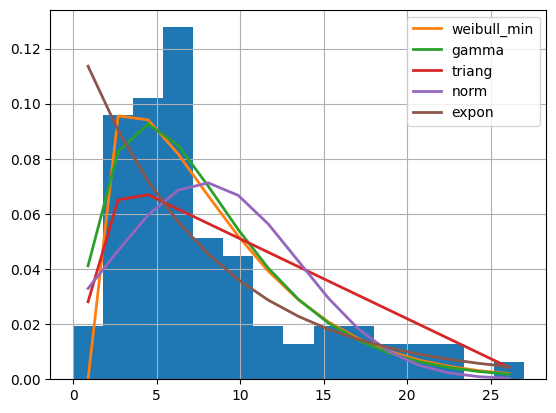

In [31]:
teach_new_mptc = mptc_activity_new[mptc_activity_new['Teach'].notnull()]['Teach']

plot_data(teach_new_mptc)
teach_fit = fit_and_analyse(teach_new_mptc)

We will further test the weibull and gamma distributions:


----------------------------------
Distribution  P-value
 Weibull_min   0.2055
       Gamma   0.1832
----------------------------------


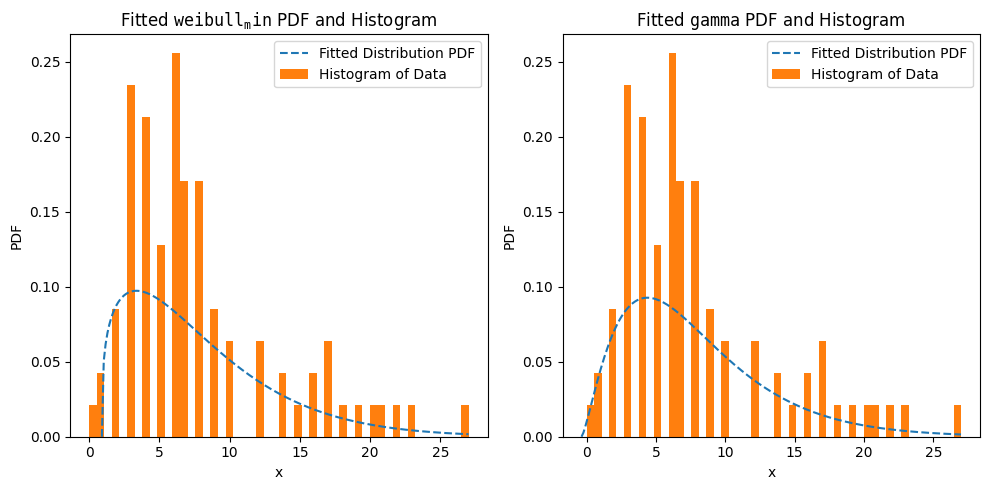

In [32]:
dist_list = ['weibull_min', 'gamma']  
goodness_of_fit(teach_new_mptc, dist_list, teach_fit)

It seems that the weibull distribution is the better fit, given our KS statistics and the goodness of fit test.

In [33]:
fit_params(teach_new_mptc, teach_fit, 'weibull_min')

----------------------------------
Weibull_min parameters:

shape: 1.3014038621229749, location: 0.9180405905282334, scale: 7.563368193948195

----------------------------------


### Resident and attending for new patients

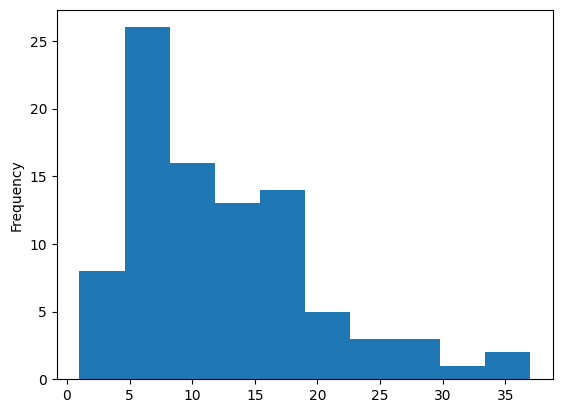

2024-04-22 10:37:06.883 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.003814)
2024-04-22 10:37:06.889 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.000783)
2024-04-22 10:37:06.913 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.000765)
2024-04-22 10:37:06.931 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.000797)
2024-04-22 10:37:06.942 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.002105)
2024-04-22 10:37:07.099 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.001556)


             sumsquare_error        aic        bic    kl_div  ks_statistic  \
gamma               0.000765  87.540936  95.073514  0.036435      0.076184   
lognorm             0.000783  88.064230  95.596809  0.035608      0.075892   
weibull_min         0.000797  86.931063  94.463641  0.040824      0.075946   
triang              0.001556  81.454990  88.987568  0.104473      0.175909   
norm                0.002105  89.790043  94.811762  0.099266      0.130157   

             ks_pvalue  
gamma         0.638263  
lognorm       0.642980  
weibull_min   0.642106  
triang        0.006206  
norm          0.083628  

----------------------------------



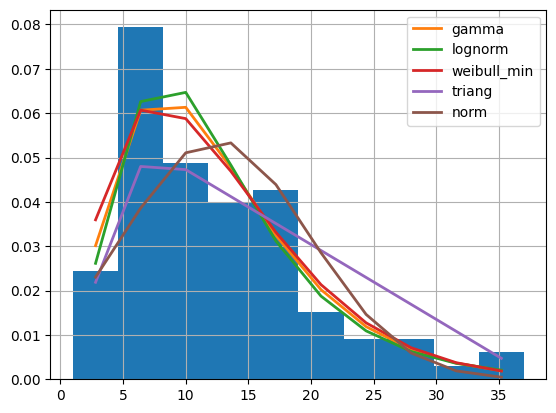

In [34]:
resident_attending = mptc_activity_new['Resident & Attending']
plot_data(resident_attending, bins = 10)
resident_attending_fit = fit_and_analyse(resident_attending, bins = 10)


The gamma and lognorm are the best candidates. We will run a goodness of fit test on these: 


----------------------------------
Distribution  P-value
       Gamma   0.6343
     Lognorm   0.6401
----------------------------------


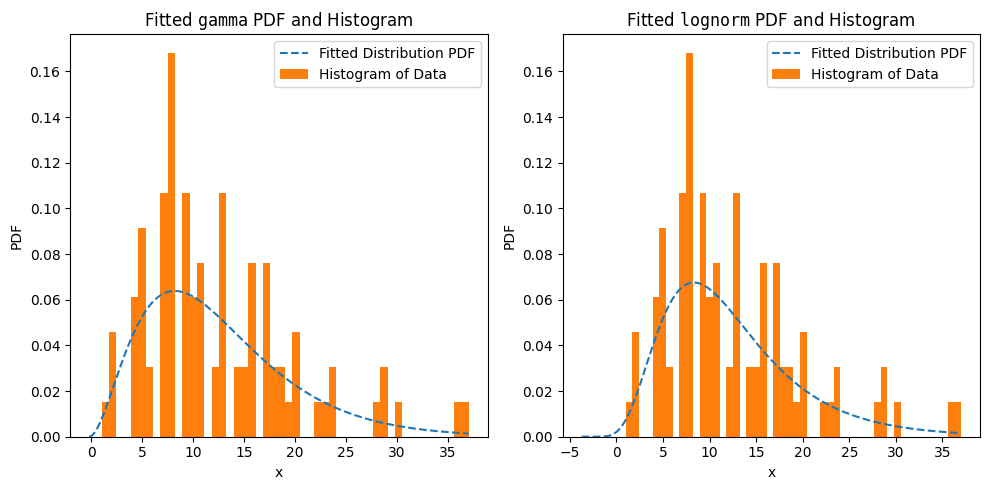

In [35]:
dist_list = [ 'gamma', 'lognorm']
goodness_of_fit(resident_attending, dist_list, resident_attending_fit)

In sum, the lognorm is the marginally better fit for these data. 

In [36]:
fit_params(resident_attending, resident_attending_fit, 'lognorm')

----------------------------------
Lognorm parameters:

shape: 0.44396208992851177, location: -3.73732116097522, scale: 14.678748559879411

----------------------------------


### Resident review returning patients

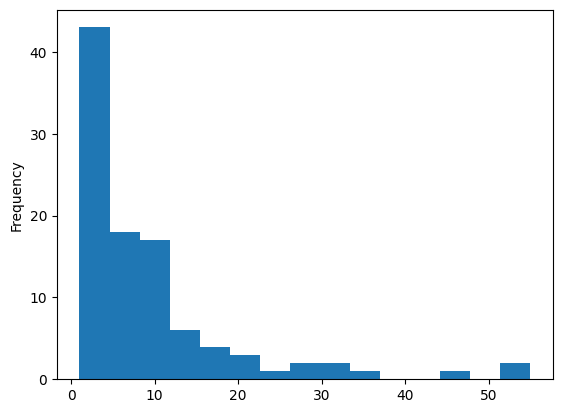

2024-04-22 10:37:08.475 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.009003)
2024-04-22 10:37:08.478 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.013711)
2024-04-22 10:37:08.592 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.002135)
2024-04-22 10:37:08.600 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.000913)
2024-04-22 10:37:08.621 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.000344)
2024-04-22 10:37:08.670 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.009824)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.000344  172.482731  180.298241     inf      0.131789   
expon               0.000913  165.078027  170.288367     inf      0.127592   
gamma               0.002135  165.630714  173.446224     inf      0.287412   
norm                0.009003  181.965958  187.176298     inf      0.233553   
triang              0.009824  136.314902  144.130413     inf      0.378381   

                ks_pvalue  
weibull_min  5.644202e-02  
expon        7.045378e-02  
gamma        8.309614e-08  
norm         2.793500e-05  
triang       2.247337e-13  

----------------------------------



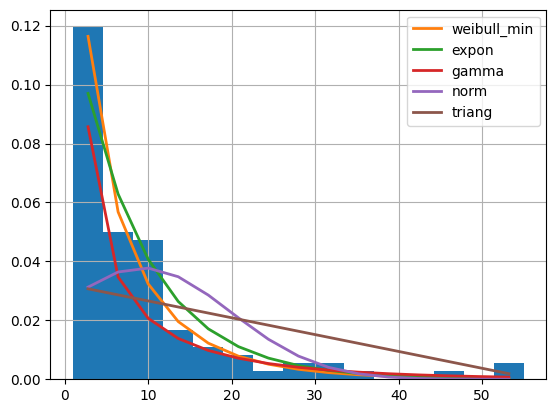

In [37]:
resident_review_return = mptc_activity_return['Resident Review']

plot_data(resident_review_return)
resident_review_return_fit = fit_and_analyse(resident_review_return)

The KS-test statistics all reject the distributions here. However, visually, the weibull, exponential and erlang seems to be the best fit.


----------------------------------
Distribution  P-value
       Expon   0.0697
 Weibull_min   0.0548
----------------------------------


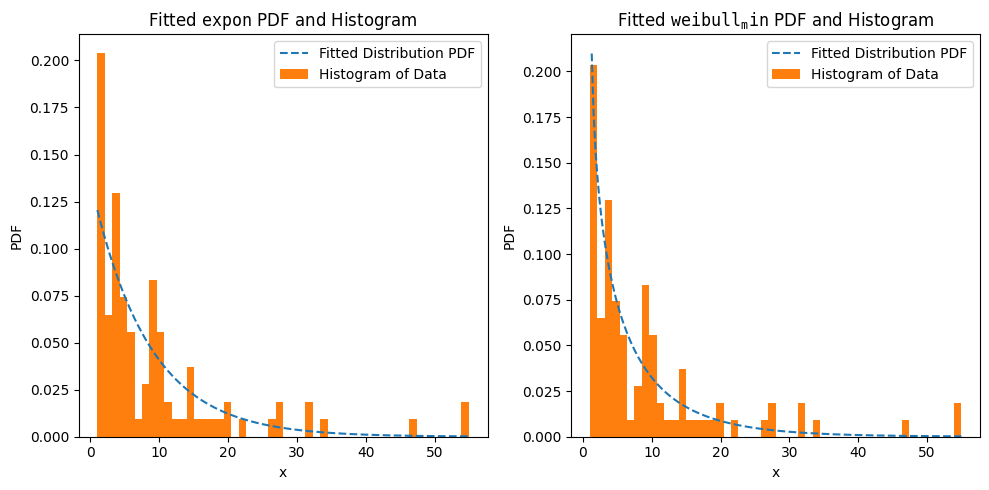

In [38]:
dist_list = ['expon', 'weibull_min']
goodness_of_fit(resident_review_return, dist_list, resident_review_return_fit)



The exponential distribution is not rejected by the goodness of fit, and seems to be the best fit over all.

In [39]:
fit_params(resident_review_return, resident_review_return_fit, 'expon')

----------------------------------
Expon parameters:

location: 0.9999999999998366, scale: 8.300000000000153

Mean exponential = 9.29999999999999

----------------------------------


### Resident and patient times for returning patients

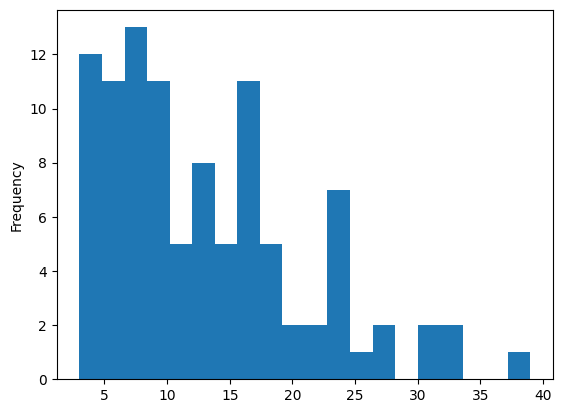

2024-04-22 10:37:09.845 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.002731)
2024-04-22 10:37:09.885 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.003267)
2024-04-22 10:37:09.897 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.003538)
2024-04-22 10:37:09.901 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.006478)
2024-04-22 10:37:09.908 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.007609)
2024-04-22 10:37:09.994 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.003915)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.002731  169.838675  177.654186     inf      0.076322   
lognorm             0.003267  172.003498  179.819009     inf      0.088056   
expon               0.003538  168.135456  173.345796     inf      0.103773   
triang              0.003915  157.010135  164.825646     inf      0.160622   
norm                0.006478  178.370879  183.581219     inf      0.119238   

             ks_pvalue  
weibull_min   0.578278  
lognorm       0.397150  
expon         0.216208  
triang        0.010123  
norm          0.107208  

----------------------------------



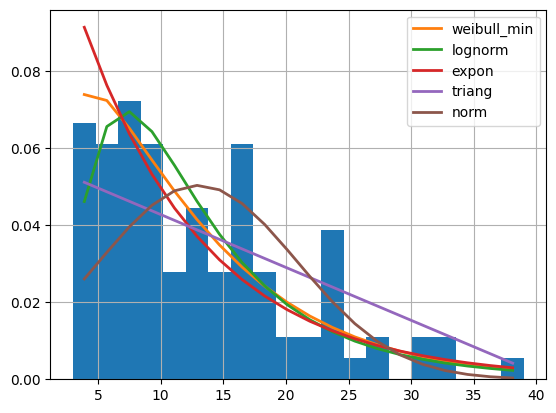

In [40]:
resident_patient_return = mptc_activity_return['Resident & Patient']

plot_data(resident_patient_return, bins = 20)
resident_patient_return_fit = fit_and_analyse(resident_patient_return, bins = 20)



We will further test the weibull, lognorm and the exponential:


----------------------------------
Distribution  P-value
       Gamma   0.0001
 Weibull_min   0.5745
       Expon   0.2132
----------------------------------


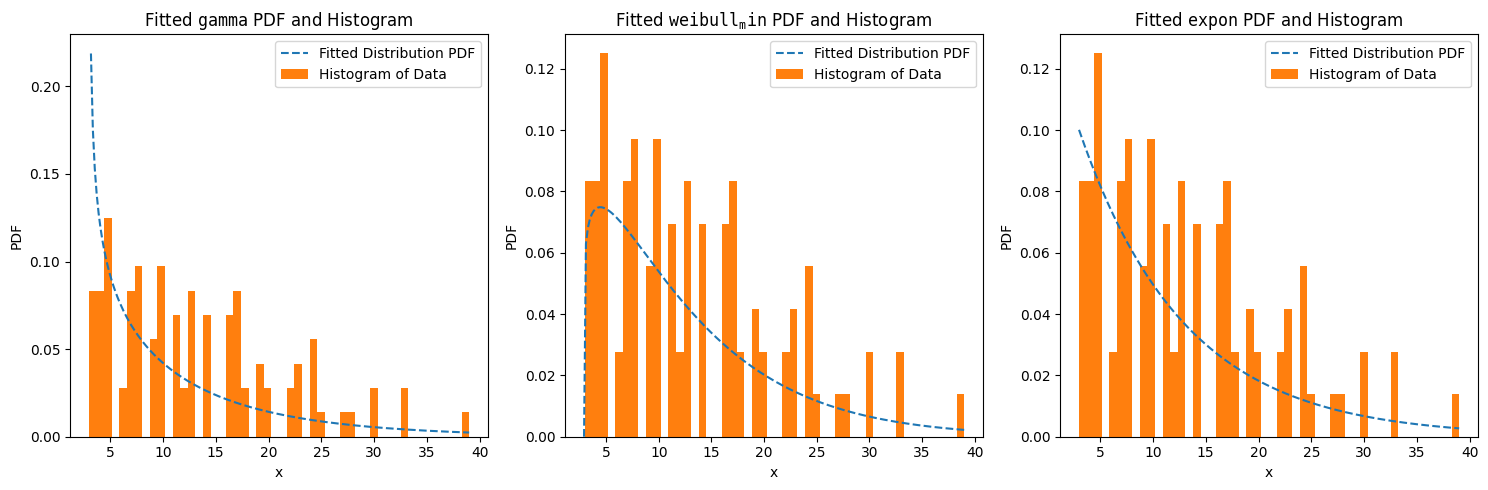

In [41]:
dist_list = ['gamma', 'weibull_min', 'expon']
goodness_of_fit(resident_patient_return, dist_list, resident_patient_return_fit)    

The weibull seems to be a better fit:

In [42]:
fit_params(resident_patient_return, resident_patient_return_fit, 'weibull_min')

----------------------------------
Weibull_min parameters:

shape: 1.1296585344307895, location: 2.8993129956443684, scale: 10.492174924693998

----------------------------------


### Teaching times for returning patients at MPTC:

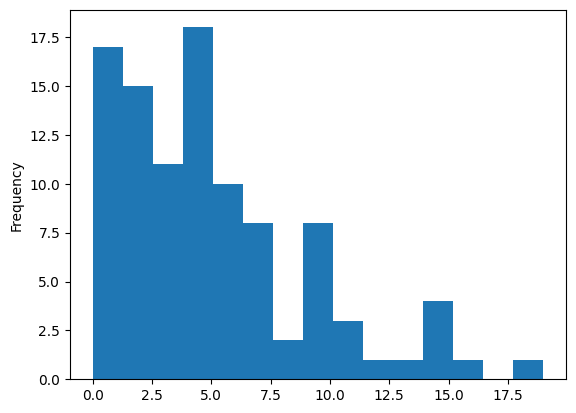

2024-04-22 10:37:11.825 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.07407)
2024-04-22 10:37:11.859 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.005624)
2024-04-22 10:37:11.861 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.006038)
2024-04-22 10:37:11.879 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.008144)
2024-04-22 10:37:11.884 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.016594)
2024-04-22 10:37:11.978 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.012247)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.005624  111.047855  118.863365     inf      0.076172   
gamma               0.006038  111.175250  118.990760     inf      0.077783   
expon               0.008144  108.411906  113.622246     inf      0.150805   
triang              0.012247  101.354318  109.169828     inf      0.209084   
norm                0.016594  118.138994  123.349334     inf      0.134187   

             ks_pvalue  
weibull_min   0.580776  
gamma         0.554166  
expon         0.018884  
triang        0.000259  
norm          0.049569  

----------------------------------



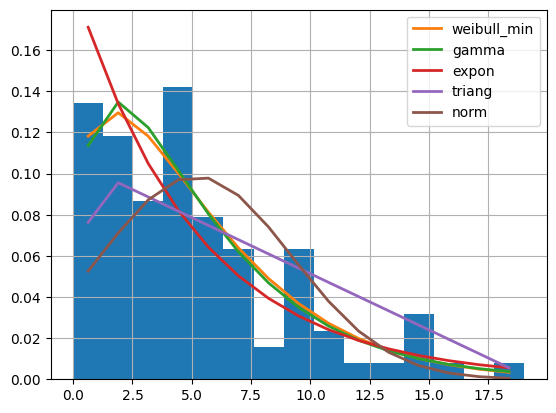

In [43]:
teach_return_mptc = mptc_activity_return['Teach']

plot_data(teach_return_mptc)
teach_return_mptc_fit = fit_and_analyse(teach_return_mptc)

We will further explore the weibull and gamma:


----------------------------------
Distribution  P-value
       Gamma   0.5554
 Weibull_min   0.5754
----------------------------------


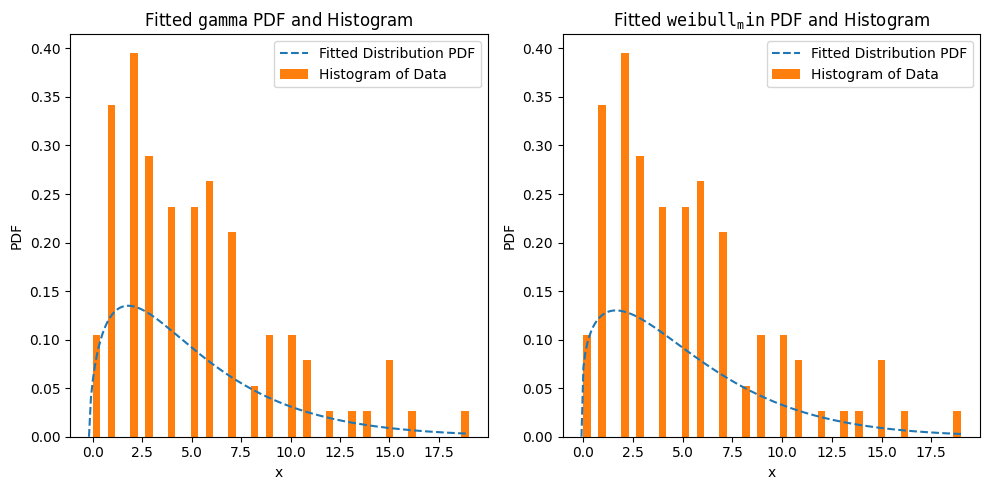

In [44]:
dist_list = ['gamma', 'weibull_min']
goodness_of_fit(teach_return_mptc, dist_list, teach_return_mptc_fit)

The goodness of fit does not reject any of the distributions. All in all, the weibull seems to be a marginally better fit when assessing all test statistics.

In [45]:
fit_params(teach_return_mptc, teach_return_mptc_fit, 'weibull_min')

----------------------------------
Weibull_min parameters:

shape: 1.2799400511602974, location: -0.09423425254828346, scale: 5.669914928265933

----------------------------------


### Resident and attending times at MPTC, returning patients

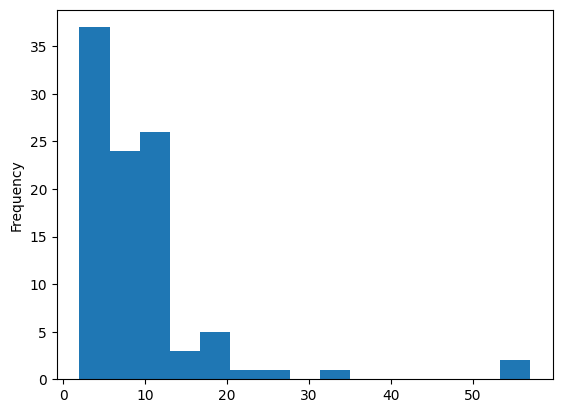

2024-04-22 10:37:13.271 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.00628)
2024-04-22 10:37:13.274 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.015317)
2024-04-22 10:37:13.368 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.011957)
2024-04-22 10:37:13.373 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.008019)
2024-04-22 10:37:13.377 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.001377)
2024-04-22 10:37:13.487 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.009375)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
expon               0.001377  177.338912  182.549253     inf      0.120000   
norm                0.006280  228.581572  233.791912     inf      0.222107   
gamma               0.008019  417.864006  425.679516     inf      0.629819   
triang              0.009375  133.606276  141.421786     inf      0.535409   
weibull_min         0.011957         inf         inf     inf      0.250000   

                ks_pvalue  
expon        1.033037e-01  
norm         8.174490e-05  
gamma        6.235949e-39  
triang       2.551018e-27  
weibull_min  5.408872e-06  

----------------------------------



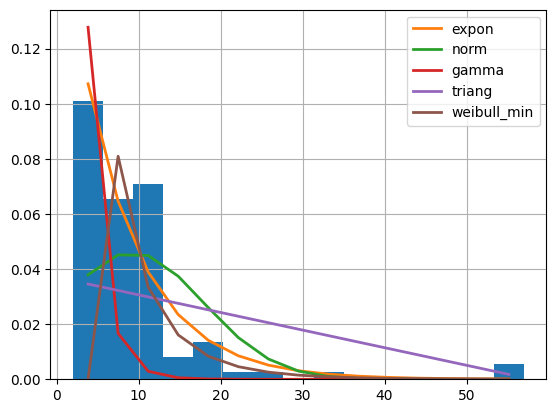

In [46]:
resident_attending_return = mptc_activity_return['Resident & Attending']

plot_data(resident_attending_return)
resident_attending_return_fit = fit_and_analyse(resident_attending_return)

The exponential distribution is the best fit, according to the KS test. It also is a better fit visually. We will further test the exponential and the normal distributions.


----------------------------------
Distribution  P-value
       Expon   0.1020
        Norm   0.0001
----------------------------------


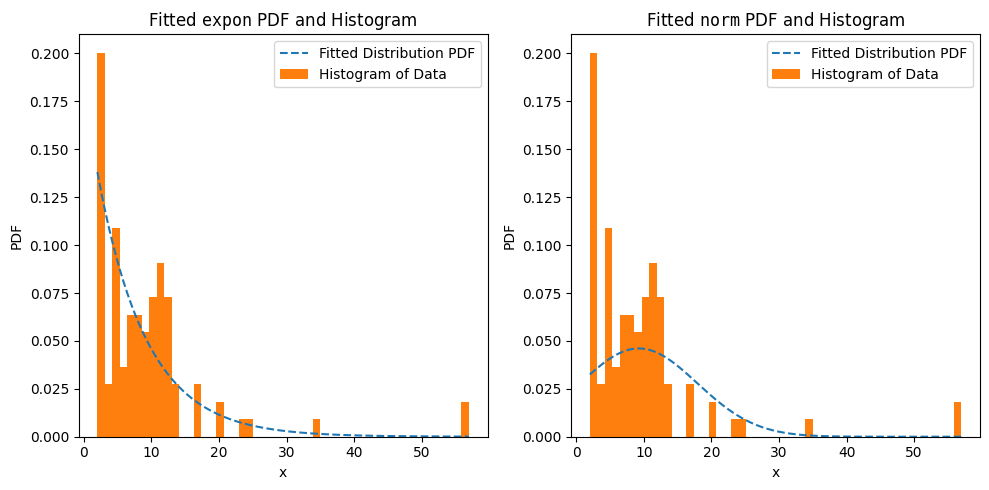

In [47]:
dist_list = ['expon', 'norm']
goodness_of_fit(resident_attending_return, dist_list, resident_attending_return_fit)

The exponential distribution is not rejected by the goodness of fit test. Visually, it also looks like an acceptable fit to our data.

In [48]:
fit_params(resident_attending_return, resident_attending_return_fit, 'expon')

----------------------------------
Expon parameters:

location: 1.999999999999993, scale: 7.240000000000009

Mean exponential = 9.240000000000002

----------------------------------


In [49]:

# convverting all collumns data types to int:
#export results as csv
results_df.to_csv("input_analysis_results.csv", index=False)

print(results_df)

   Distribution   Location      Scale     Shape       Mean
0       Lognorm  -0.341781   4.048762  0.538517        NaN
1         Gamma   0.567385   0.788478  3.751359   3.525249
2       Lognorm   1.534562  17.655086  0.593968        NaN
3         Expon   1.000000   3.724490       NaN   4.724490
4          Norm -24.090000  24.644308       NaN        NaN
5          Norm -25.547945  16.026554       NaN        NaN
6   Weibull_min   0.988903   9.648656  1.047625        NaN
7         Gamma   3.132092   7.380830  2.306444  20.155563
8   Weibull_min   0.918041   7.563368  1.301404        NaN
9       Lognorm  -3.737321  14.678749  0.443962        NaN
10        Expon   1.000000   8.300000       NaN   9.300000
11  Weibull_min   2.899313  10.492175  1.129659        NaN
12  Weibull_min  -0.094234   5.669915  1.279940        NaN
13        Expon   2.000000   7.240000       NaN   9.240000


## Scenario analysis

2024-04-22 10:37:14.408 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.057912)
2024-04-22 10:37:14.491 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.007226)
2024-04-22 10:37:14.494 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.016713)
2024-04-22 10:37:14.504 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.007386)


2024-04-22 10:37:14.508 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.002994)
2024-04-22 10:37:14.568 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.017031)
2024-04-22 10:37:14.666 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.061037)
2024-04-22 10:37:14.671 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.166226)
2024-04-22 10:37:14.726 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.045574)
2024-04-22 10:37:14.731 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.014618)
2024-04-22 10:37:14.736 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.015706)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
gamma               0.002994  132.590097  140.122675     inf      0.108573   
expon               0.007226  125.415764  130.437483     inf      0.172842   
weibull_min         0.007386  129.808895  137.341473     inf      0.098952   
norm                0.016713  150.093789  155.115508     inf      0.182330   
triang              0.017031  109.443455  116.976033     inf      0.323058   

                ks_pvalue  
gamma        2.173064e-01  
expon        7.571922e-03  
weibull_min  3.140290e-01  
norm         4.044242e-03  
triang       5.940644e-09  

----------------------------------



2024-04-22 10:37:14.812 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.035619)
2024-04-22 10:37:14.866 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.054843)
2024-04-22 10:37:14.871 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.036013)
2024-04-22 10:37:14.964 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.008542)
2024-04-22 10:37:14.976 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.003652)
2024-04-22 10:37:15.025 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.001376)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.014618         inf         inf     inf      0.111972   
gamma               0.015706  101.857503  109.255227     inf      0.115618   
triang              0.035619   90.506209   97.903934     inf      0.268832   
norm                0.045574  106.729231  111.661047     inf      0.201986   
expon               0.061037   96.611767  101.543583     inf      0.237139   

             ks_pvalue  
weibull_min   0.209126  
gamma         0.180551  
triang        0.000005  
norm          0.001375  
expon         0.000087  

----------------------------------



2024-04-22 10:37:15.062 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.039297)
2024-04-22 10:37:15.267 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.296273)


             sumsquare_error         aic         bic  kl_div  ks_statistic  \
weibull_min         0.001376  151.688315  159.503826     inf      0.131789   
expon               0.003652  144.283611  149.493952     inf      0.127592   
gamma               0.008542  144.836298  152.651809     inf      0.287412   
norm                0.036013  161.171543  166.381883     inf      0.233553   
triang              0.039297  115.520373  123.335883     inf      0.378382   

                ks_pvalue  
weibull_min  5.644202e-02  
expon        7.045378e-02  
gamma        8.309614e-08  
norm         2.793500e-05  
triang       2.247043e-13  

----------------------------------



2024-04-22 10:37:15.300 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted weibull_min distribution with error=0.022495)
2024-04-22 10:37:15.311 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.024154)
2024-04-22 10:37:15.337 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.066378)
2024-04-22 10:37:15.342 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.032576)
2024-04-22 10:37:15.435 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted triang distribution with error=0.048989)


             sumsquare_error        aic         bic  kl_div  ks_statistic  \
weibull_min         0.022495  90.253893   98.069403     inf      0.076171   
gamma               0.024154  90.380972   98.196482     inf      0.077788   
expon               0.032576  87.617491   92.827831     inf      0.150805   
triang              0.048989  80.559680   88.375190     inf      0.209086   
norm                0.066378  97.344578  102.554919     inf      0.134187   

             ks_pvalue  
weibull_min   0.580799  
gamma         0.554075  
expon         0.018884  
triang        0.000259  
norm          0.049569  

----------------------------------

----------------------------------
Weibull_min parameters:

shape: 1.0476275617295194, location: 0.494451062339589, scale: 4.824321685860996

----------------------------------
----------------------------------
Weibull_min parameters:

shape: 1.3013891410210698, location: 0.4590306235617775, scale: 3.781675063819484

------------------------------

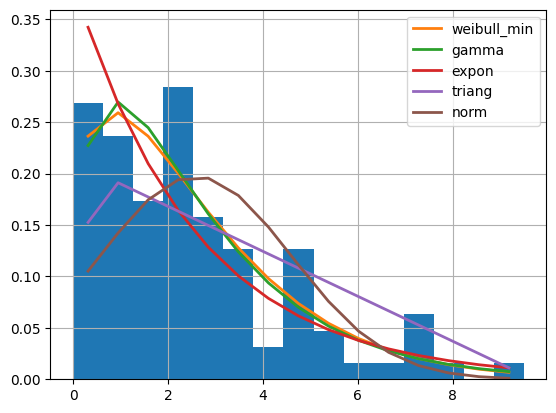

In [50]:

# halving the data and fitting it again
resident_review_new_halved = resident_review_new/2
teacher_new_mptc_halved = teach_new_mptc/2

resident_review_return_halved = resident_review_return/2 
teach_return_mptc_halved = teach_return_mptc/2


resident_review_new_halved_fit = fit_and_analyse(resident_review_new_halved)
teacher_new_mptc_halved_fit = fit_and_analyse(teacher_new_mptc_halved)

resident_review_return_halved_fit = fit_and_analyse(resident_review_return_halved)
teach_return_mptc_halved_fit = fit_and_analyse(teach_return_mptc_halved)

# getting fit params
fit_params(resident_review_new_halved, resident_review_new_halved_fit, 'weibull_min')
fit_params(teacher_new_mptc_halved, teacher_new_mptc_halved_fit, 'weibull_min')

fit_params(resident_review_return_halved, resident_review_return_halved_fit, 'expon')
fit_params(teach_return_mptc_halved, teach_return_mptc_halved_fit, 'weibull_min')
